In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Load MNIST dataset
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
X_train = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
X_test = mnist.test.images  # Returns np.array
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)

to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(train_labels,10)
y_test = to_categorical(test_labels,10)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [3]:
def model(x, training=False):
    input_layer = tf.reshape(x, [-1, 28, 28, 1])
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=training)
    logits = tf.layers.dense(inputs=dropout, units=10)
    y = tf.nn.softmax(logits, name="softmax_tensor")
    return y, logits

class Dummy:
    pass
                                               
def evaluate(sess, env, X_data, y_data, batch_size=128):
    print('Evaluating...')
    loss, acc = sess.run([env.loss, env.acc], feed_dict={env.x: X_data, env.y: y_data})
    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

def train(sess, env, X_data, y_data, X_valid=None, y_valid=None, epochs=1,
          load=False, shuffle=True, batch_size=128, name='model'):
    print('\nTrain model')
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    for epoch in range(epochs):
        print('\nEpoch {0}/{1}'.format(epoch + 1, epochs))

        if shuffle:
            print('\nShuffling data')
            ind = np.arange(n_sample)
            np.random.shuffle(ind)
            X_data = X_data[ind]
            y_data = y_data[ind]

        for batch in range(n_batch):
            print(' batch {0}/{1}\r'.format(batch + 1, n_batch))
            start = batch * batch_size
            end = min(n_sample, start + batch_size)
            sess.run(env.train_op, feed_dict={env.x: X_data[start:end],
                                              env.y: y_data[start:end],
                                              env.training: True})
        if X_valid is not None:
            evaluate(sess, env, X_valid, y_valid)
                      
def predict(sess, env, X_data):
    print('Predicting...')
    return sess.run(env.ybar, feed_dict={env.x: X_data})

def fgm(x, preds, y, eps=0.3): 
    inner_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=preds)
    loss = tf.reduce_mean(inner_loss)
    loss = -loss # According to cleverhans, needed if it is targetted fgm
    grad, = tf.gradients(loss, x)
    normalized_grad = tf.sign(grad)
    normalized_grad = tf.stop_gradient(normalized_grad)

    adv_x = x + eps * normalized_grad
    adv_x = tf.clip_by_value(adv_x, 0, 1)

    return adv_x

def make_fgm(sess, env, x, adv_y, eps):
    return sess.run(env.fgm, feed_dict={
        env.x: x,
        env.adv_y: adv_y,
        env.adv_eps: eps
    })

In [4]:
tf.reset_default_graph()

env = Dummy()

with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, 784), name='x')
    env.y = tf.placeholder(tf.float32, (None, 10), name='y')
    env.training = tf.placeholder_with_default(False, (), name='mode')

    env.ybar, logits = model(env.x, training=env.training)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits_v2(labels=env.y, logits=logits)
        env.loss = tf.reduce_mean(xent, name='loss')

    with tf.variable_scope('train_op'):
        optimizer = tf.train.AdamOptimizer()
        env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.train.Saver()

with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
    env.adv_eps = tf.placeholder(tf.float32, (), name='adv_eps')
    env.adv_y = tf.placeholder(tf.int32, (None, 10), name='adv_y')
    env.fgm = fgm(x=env.x, y=env.adv_y, preds=env.ybar, eps=env.adv_eps)
print('Initializing graph')
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

Initializing graph


In [5]:
train(sess, env, X_train, y_train, epochs=1, name='mnist')
evaluate(sess, env, X_test, y_test)


Train model

Epoch 1/1

Shuffling data
 batch 1/430
 batch 2/430
 batch 3/430
 batch 4/430
 batch 5/430
 batch 6/430
 batch 7/430
 batch 8/430
 batch 9/430
 batch 10/430
 batch 11/430
 batch 12/430
 batch 13/430
 batch 14/430
 batch 15/430
 batch 16/430
 batch 17/430
 batch 18/430
 batch 19/430
 batch 20/430
 batch 21/430
 batch 22/430
 batch 23/430
 batch 24/430
 batch 25/430
 batch 26/430
 batch 27/430
 batch 28/430
 batch 29/430
 batch 30/430
 batch 31/430
 batch 32/430
 batch 33/430
 batch 34/430
 batch 35/430
 batch 36/430
 batch 37/430
 batch 38/430
 batch 39/430
 batch 40/430
 batch 41/430
 batch 42/430
 batch 43/430
 batch 44/430
 batch 45/430
 batch 46/430
 batch 47/430
 batch 48/430
 batch 49/430
 batch 50/430
 batch 51/430
 batch 52/430
 batch 53/430
 batch 54/430
 batch 55/430
 batch 56/430
 batch 57/430
 batch 58/430
 batch 59/430
 batch 60/430
 batch 61/430
 batch 62/430
 batch 63/430
 batch 64/430
 batch 65/430
 batch 66/430
 batch 67/430
 batch 68/430
 batch 69/430
 ba

(0.04328598, 0.9859)

Evaluating...
 loss: 0.0375 acc: 0.9890
Evaluating...
 loss: 0.5748 acc: 0.7780
Predicting...
Predicting...


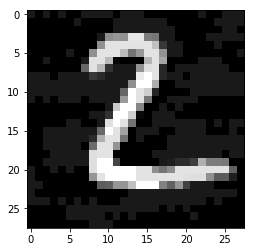

In [6]:
num_adv_imgs = 1000

idxs_of_two = np.where(test_labels == 2)[0][:num_adv_imgs]
evaluate(sess, env, X_test[idxs_of_two], y_test[idxs_of_two])
adv_y = np.tile(to_categorical(6,10), (num_adv_imgs,1))
X_adv_flat = make_fgm(sess, env, x=X_test[idxs_of_two], adv_y=adv_y, eps=0.1)
evaluate(sess, env, X_adv_flat, y_test[idxs_of_two])
X_adv = np.reshape(X_adv_flat, (num_adv_imgs,28,28))
plt.imshow(X_adv[0], cmap='gray')

adv_preds = predict(sess, env, X_adv_flat)
orig_preds = predict(sess, env, X_test[idxs_of_two])

In [9]:
def breakdown_preds(preds):
    unique, counts = np.unique(np.argmax(preds, axis=1), return_counts=True)
    return dict(zip(unique, counts))
print('adversarial predicitons breakdown', breakdown_preds(adv_preds))
print('original predicitons breakdown', breakdown_preds(orig_preds))

('adversarial predicitons breakdown', {0: 23, 1: 28, 2: 778, 3: 55, 4: 15, 5: 2, 6: 15, 7: 53, 8: 28, 9: 3})
('original predicitons breakdown', {0: 6, 1: 3, 2: 989, 6: 1, 7: 1})


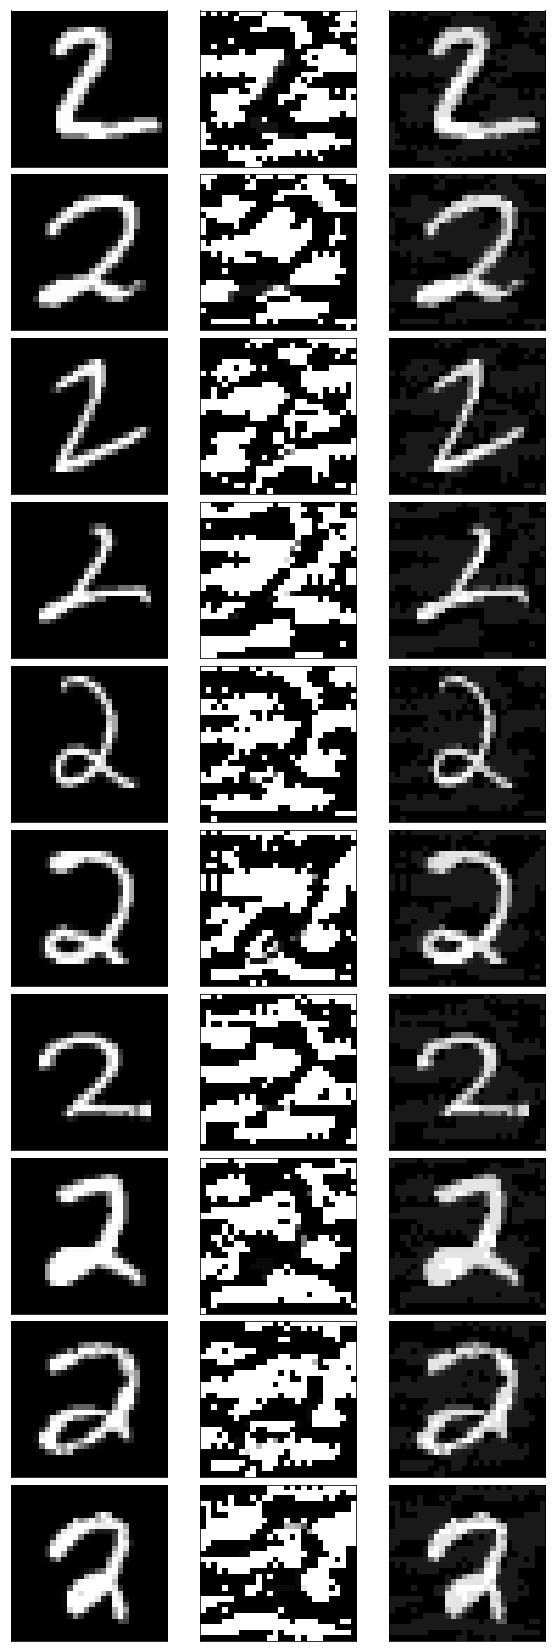

In [10]:
fig = plt.figure(figsize=(10, 30))
gs = gridspec.GridSpec(10, 3, wspace=0.05, hspace=0.05)

for i in range(10):
    orig_img = np.reshape(X_test[idxs_of_two[i]], (28,28))
    adv_img = X_adv[i]
    noise_img = np.clip(adv_img - orig_img, 0, 1)
    ax = fig.add_subplot(gs[i, 0])
    ax.imshow(orig_img, cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(gs[i, 1])
    ax.imshow(noise_img, cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(gs[i, 2])
    ax.imshow(adv_img, cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])